## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [6]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [8]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [9]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [10]:
target = 'survived'

In [11]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']

vars_cat = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables

vars_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().sum()

age     263
fare      1
dtype: int64

In [13]:
# now in categorical variables
vars_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().sum()


cabin       1014
embarked       2
dtype: int64

In [17]:
# data['cabin'].isnull().sum()
data.shape

(1309, 10)

### Determine cardinality of categorical variables

In [18]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

In [19]:
discrete_vars = [var for var in vars_num if len(data[var].unique()) < 20]

In [20]:
# make list of continuous variables
cont_vars = [var for var in vars_num if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars))
# cont_vars

Number of continuous variables:  2


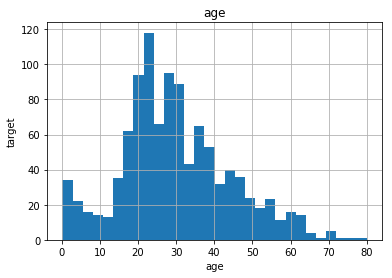

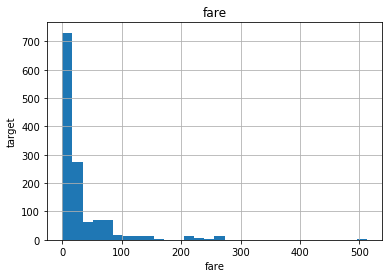

In [21]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('target')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_continuous(data, var)

In [22]:
target

'survived'

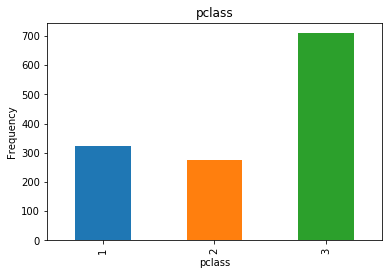

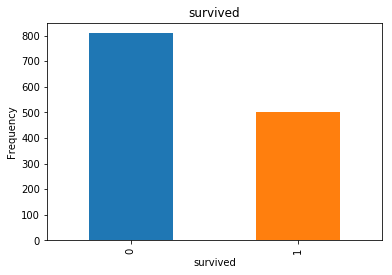

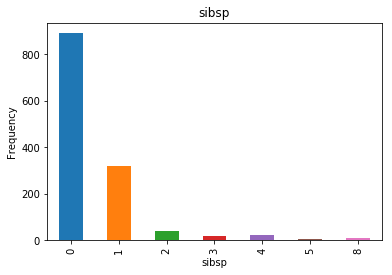

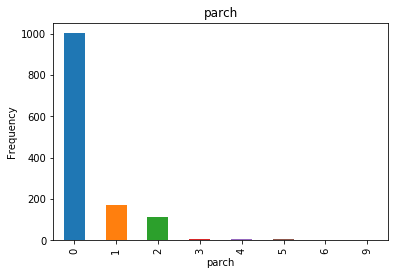

In [23]:
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)['survived'].count().plot.bar()
    plt.title(var)
    plt.ylabel('Frequency')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [45]:
# re.sub(r'[0-9]+', '', 'A55')
# [re.sub('a','B',x) for str(x) in data['cabin']]
# re.sub('a','A','aAA')
X_train['cabin'] = [re.sub(r'[0-9]+', '', x) if not pd.isna(x) else x for x in X_train['cabin']]
X_test['cabin'] = [re.sub(r'[0-9]+', '', x) if not pd.isna(x) else x for x in X_test['cabin']]
# np.isnan(data.loc[9,'cabin'])
# [print(x) for x in data['cabin']]
# np.isnan()
# np.isnan(data.loc[9,'cabin'])
# [ for x in data['cabin'][0:10]]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [46]:
vars_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]
for var in vars_with_na:

    # calculate the mode using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [47]:
# replace missing values with new label: "Missing"
vars_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]
X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [48]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [49]:
# let's capture the categorical variables in a list

cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

In [50]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['fare'].count() / len(df)

    return tmp[tmp > rare_perc].index

In [51]:
X_train.fare.isnull().sum()

0

In [52]:
for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [55]:
for var in cat_vars:
    X_train = X_train[X_train[var]!='Rare']
    X_test = X_test[X_test[var]!='Rare']

In [54]:
X_test['cabin'].unique()

array(['Missing', 'Rare', 'C'], dtype=object)

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [31]:
# def replace_categories(train, test, var, target):

#     # order the categories in a variable from that with the lowest
#     # house sale price, to that with the highest
#     ordered_labels = train.groupby([var])[target].mean().sort_values().index

#     # create a dictionary of ordered categories to integer values
#     ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

#     # use the dictionary to replace the categorical strings by integers
#     train[var] = train[var].map(ordinal_label)
#     test[var] = test[var].map(ordinal_label)

In [32]:
# for var in cat_vars:
#     replace_categories(X_train, X_test, var, 'fare')

In [58]:
z = X_train[[x for x in X_train.columns if x not in vars_cat]].copy()

for var in vars_cat:
    y = pd.get_dummies(X_train[var], prefix=var)
#     print(y)
    col = list(z.columns)+list(y.columns)
    z = pd.concat([z, y], axis=1, sort=False, ignore_index=True)
    z.columns = col
    z = z.iloc[:, :-1]

In [59]:
z

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,cabin_C,embarked_C,embarked_Q,title_Miss,title_Mr
1118,3,25.0000,0,0,7.9250,0,0,0,0,0,0,0,1
1072,3,28.0000,0,0,7.7333,1,0,0,0,0,1,0,1
1130,3,18.0000,0,0,7.7750,0,0,1,0,0,0,1,0
574,2,29.0000,1,0,21.0000,0,0,0,0,0,0,0,1
500,2,46.0000,0,0,26.0000,0,0,0,0,0,0,0,1
958,3,28.0000,0,4,25.4667,1,0,1,0,0,0,0,0
322,1,36.0000,0,0,135.6333,0,0,1,1,1,0,1,0
703,3,21.0000,0,0,7.7500,0,0,0,0,0,1,0,1
668,3,22.0000,0,0,8.0500,0,0,0,0,0,0,0,1
1221,3,28.0000,0,0,7.8958,1,0,0,0,0,0,0,1


In [60]:
X_train = z.copy()

In [61]:
z = X_test[[x for x in X_test.columns if x not in vars_cat]].copy()

for var in vars_cat:
    y = pd.get_dummies(X_test[var], prefix=var)
#     print(y)
    col = list(z.columns)+list(y.columns)
    z = pd.concat([z, y], axis=1, sort=False, ignore_index=True)
    z.columns = col
    z = z.iloc[:, :-1]

In [62]:
z

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,cabin_C,embarked_C,embarked_Q,title_Miss,title_Mr
1139,3,38.0,0,0,7.8958,0,0,0,0,0,0,0,1
533,2,21.0,0,1,21.0000,0,0,1,0,0,0,1,0
459,2,42.0,1,0,27.0000,0,0,0,0,0,0,0,1
1150,3,28.0,0,0,14.5000,1,0,0,0,0,0,0,1
393,2,25.0,0,0,31.5000,0,0,0,0,0,0,0,1
330,2,57.0,0,0,13.0000,0,0,0,0,0,0,0,1
887,3,28.0,0,0,8.1125,1,0,0,0,0,0,0,1
531,2,28.0,0,0,15.0500,1,0,0,0,1,0,0,1
790,3,39.0,0,2,7.2292,0,0,0,0,1,0,0,1
1260,3,18.0,0,0,9.8417,0,0,1,0,0,0,1,0


In [63]:
X_test = z.copy()

In [64]:

y_train = y_train[y_train.index.isin(list(X_train.index))]
y_test = y_test[y_test.index.isin(list(X_test.index))]


### Scale the variables

- Use the standard scaler from Scikit-learn

In [66]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train_sc = scaler.transform(X_train)

X_test_sc = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [67]:
# set up the model
# remember to set the random_state / seed

logit_model = LogisticRegression(C=0.005, random_state=0)

# train the model

logit_model.fit(X_train_sc, y_train)

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [68]:
# evaluate the model:
# ====================

# remember that we log transformed the output (SalePrice)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = logit_model.predict(X_train_sc)

In [69]:
pred_proba = logit_model.predict_proba(X_train_sc)[:,1]

In [70]:
# determine mse and rmse
# accuracy_score, roc_auc_score
print('train accuracy:',accuracy_score(y_train, pred))
print('roc_auc_score train:',roc_auc_score(y_train, pred_proba))

train accuracy: 0.7946537059538274
roc_auc_score train: 0.8286283571093697


In [71]:
# make predictions for test set
pred = logit_model.predict(X_test_sc)
pred_prob = logit_model.predict_proba(X_test_sc)[:,1]
# determine mse and rmse
print('test accuracy:',accuracy_score(y_test, pred))
print('roc_auc_score:',roc_auc_score(y_test, pred_prob))


test accuracy: 0.8047619047619048
roc_auc_score: 0.8203388047138047


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [72]:
# we persist the model for future use
joblib.dump(logit_model, 'logit_regression.pkl')

['logit_regression.pkl']